In [1]:
# ! pip install beautifulsoup4

### **Hydro-JULES: Global high-resolution drought datasets from 1981-2022**
dataset website
1. https://catalogue.ceda.ac.uk/uuid/ac43da11867243a1bb414e1637802dec/
2. https://catalogue.ceda.ac.uk/uuid/e652f0109f21401680bc3c0ac834a96e/


In [2]:
import requests
from bs4 import BeautifulSoup

In [3]:
url = r'https://data.ceda.ac.uk/badc/hydro-jules/data/Global_drought_indices/MSWEP_hPET'

In [4]:
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

In [5]:
nc_files = []

for a in soup.find_all('a'):
    href = a.get('href', '')
    # print(href)
    if href.endswith('.nc.html'):
        nc_url = href.replace('.html', '')
        nc_files.append(nc_url)

print(nc_files)


['https://dap.ceda.ac.uk/thredds/dodsC/badc/hydro-jules/data/Global_drought_indices/MSWEP_hPET/spei01.nc', 'https://dap.ceda.ac.uk/thredds/dodsC/badc/hydro-jules/data/Global_drought_indices/MSWEP_hPET/spei02.nc', 'https://dap.ceda.ac.uk/thredds/dodsC/badc/hydro-jules/data/Global_drought_indices/MSWEP_hPET/spei03.nc', 'https://dap.ceda.ac.uk/thredds/dodsC/badc/hydro-jules/data/Global_drought_indices/MSWEP_hPET/spei04.nc', 'https://dap.ceda.ac.uk/thredds/dodsC/badc/hydro-jules/data/Global_drought_indices/MSWEP_hPET/spei05.nc', 'https://dap.ceda.ac.uk/thredds/dodsC/badc/hydro-jules/data/Global_drought_indices/MSWEP_hPET/spei06.nc', 'https://dap.ceda.ac.uk/thredds/dodsC/badc/hydro-jules/data/Global_drought_indices/MSWEP_hPET/spei07.nc', 'https://dap.ceda.ac.uk/thredds/dodsC/badc/hydro-jules/data/Global_drought_indices/MSWEP_hPET/spei08.nc', 'https://dap.ceda.ac.uk/thredds/dodsC/badc/hydro-jules/data/Global_drought_indices/MSWEP_hPET/spei09.nc', 'https://dap.ceda.ac.uk/thredds/dodsC/badc/hy

In [6]:
import xarray as xr
spei6_url = nc_files[5]
print(spei6_url)
ds = xr.open_dataset(spei6_url)

https://dap.ceda.ac.uk/thredds/dodsC/badc/hydro-jules/data/Global_drought_indices/MSWEP_hPET/spei06.nc


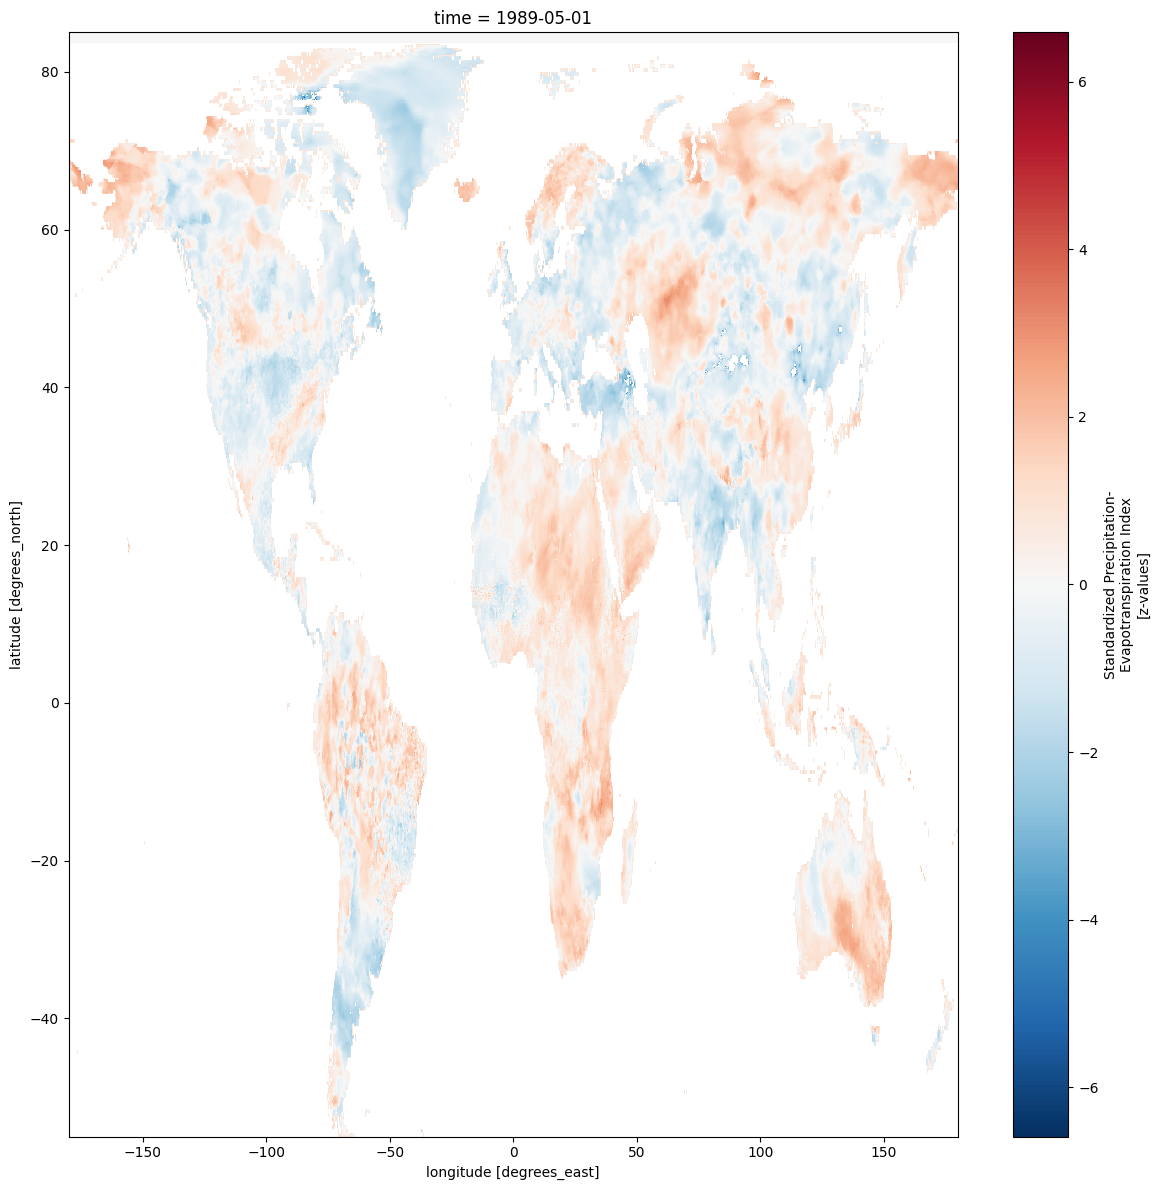

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (12,12))
ds.spei.isel(time=100).plot(ax= ax)
plt.tight_layout()
plt.show()

#### clipping data for the Niedersachen

In [8]:
import geopandas as gpd

<Axes: >

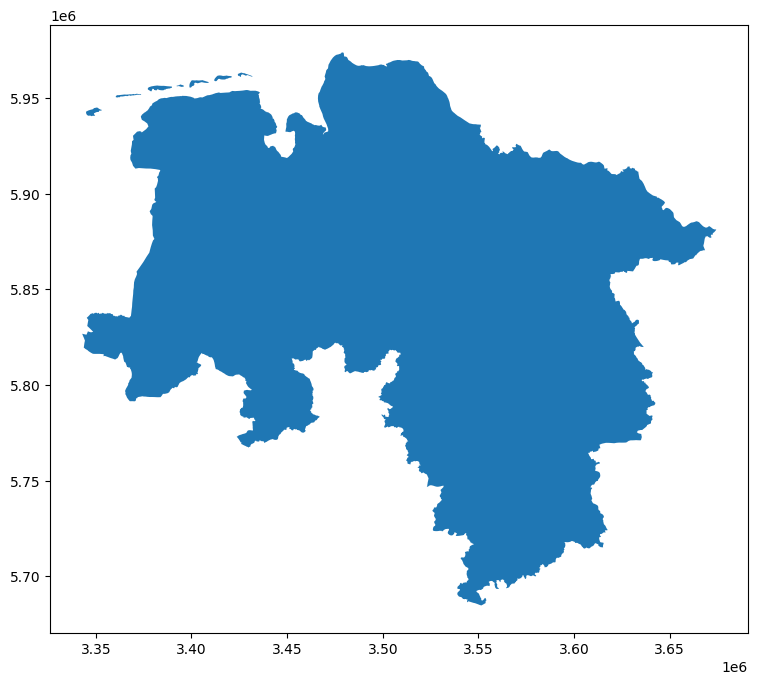

In [9]:
lx = gpd.read_file(r'C:\Users\Pandit\Downloads\Lager_Hase_R\Lager_Hase\data\spatial data\administration\niedersachsen_grenze.shp')
fig, ax = plt.subplots(figsize = (9,9))
lx.plot(ax = ax)

In [10]:
lx_bounds = lx.total_bounds

In [11]:
lx_bounds

array([3342868.        , 5684821.99992246, 3674310.        ,
       5973896.00007754])

convert them also into same coordinate system

In [12]:
# wgs coordinate system of the shape file
lx_4326 = lx.to_crs('EPSG:4326')
lx_4326_bound = lx_4326.total_bounds
lx_4326_bound

array([ 6.65691261, 51.2919306 , 11.5984934 , 53.89157228])

In [13]:
# clipping the data to lx region
import rioxarray
# define the crs to the spei file
ds = ds.rio.write_crs('EPSG:4326')
ds_lx = ds.rio.clip_box(*lx_4326_bound)

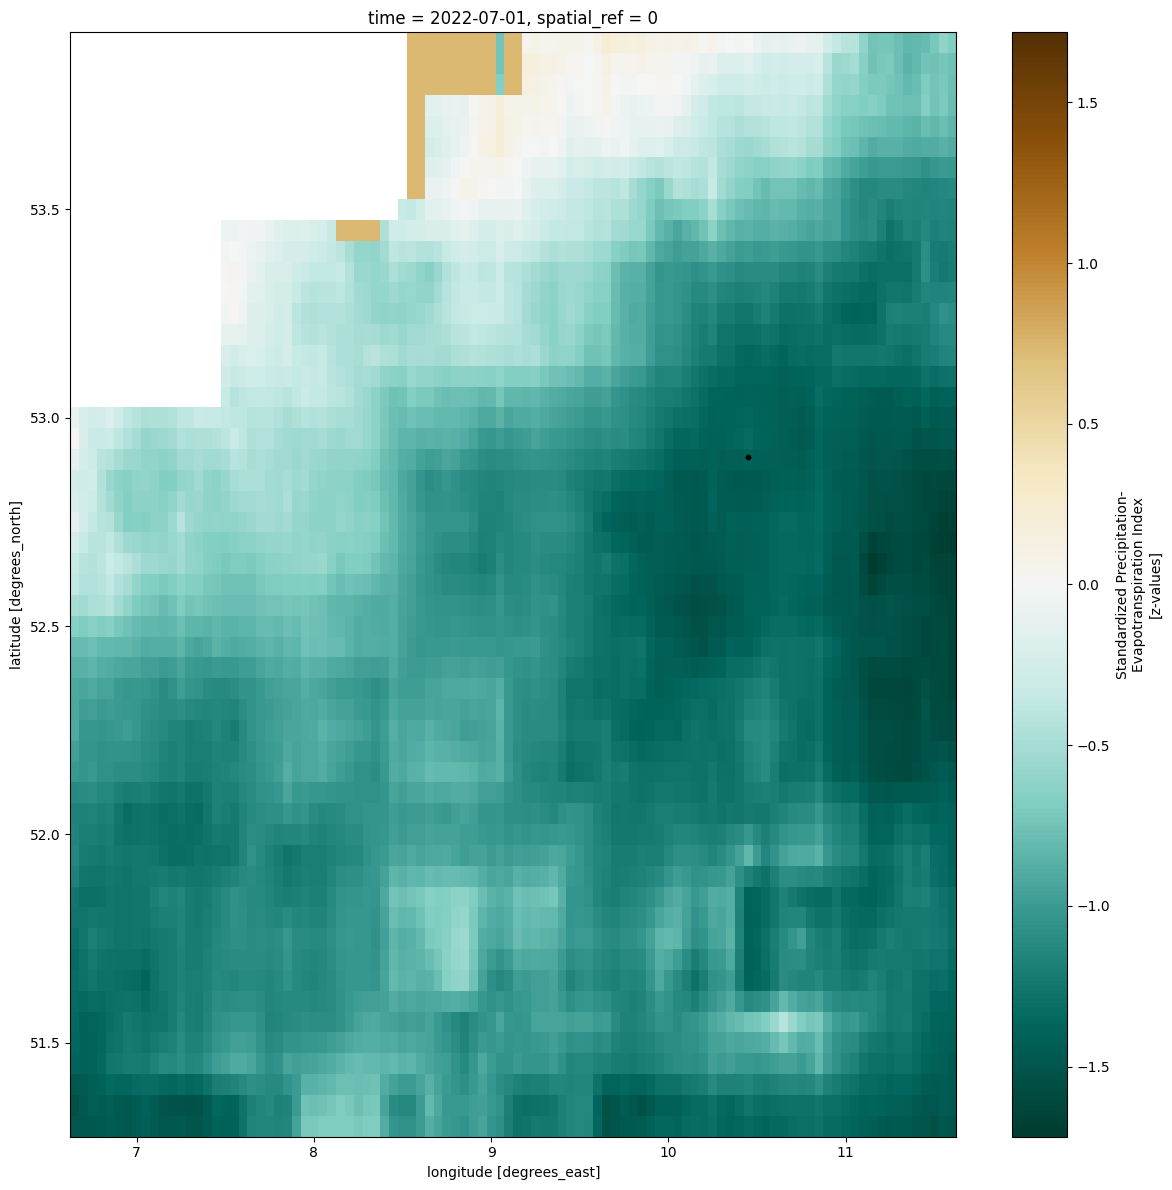

In [14]:
fig, ax = plt.subplots(figsize = (12,12))
ds_lx.spei.sel(time = '2022-07-01' ).plot(ax= ax, cmap='BrBG_r')
ax.scatter(x=10.451666, y=52.90611, color = 'black', s = 10)
plt.tight_layout()

#### data for hamerstorf

In [15]:
hamerstorf_ds = ds_lx.interp(lon=10.451666, lat=52.90611, method='linear')

In [16]:
ham_spei = hamerstorf_ds.to_dataframe()

In [17]:
ham_spei.index

DatetimeIndex(['1981-01-01', '1981-02-01', '1981-03-01', '1981-04-01',
               '1981-05-01', '1981-06-01', '1981-07-01', '1981-08-01',
               '1981-09-01', '1981-10-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', name='time', length=504, freq=None)

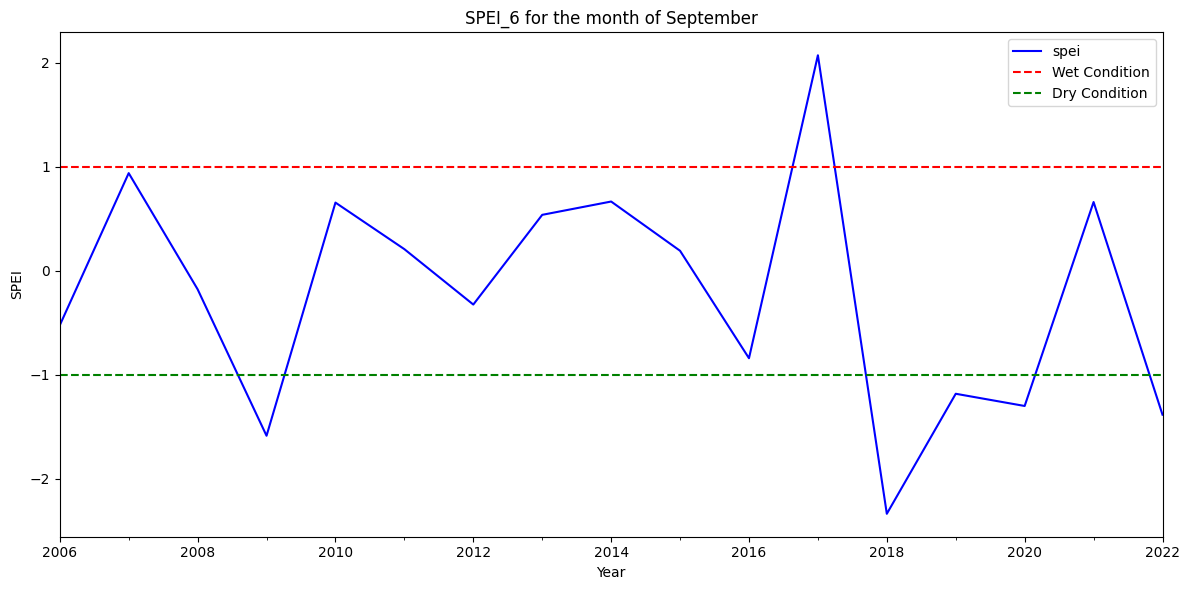

In [18]:
import datetime
import pandas as pd
spei_6_sept = ham_spei[ham_spei.index.month == 9]

fig,ax = plt.subplots(figsize = (12,6))
spei_6_sept['spei'].plot(ax = ax , color = 'blue')
plt.axhline(1, linestyle = '--', color = 'red', label = 'Wet Condition')
plt.axhline(-1, linestyle = '--', color = 'green', label = 'Dry Condition')
plt.title('SPEI_6 for the month of September')
plt.ylabel('SPEI')
plt.xlabel('Year')
plt.xlim(pd.to_datetime('2006-07-01'), pd.to_datetime('2022-07-01'))
plt.legend()
plt.tight_layout()
plt.show()

### Function to download the data based on the pcp and et product

In [19]:
import requests
from bs4 import BeautifulSoup

In [20]:
def url_extraction(url, spei_index):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # list of the links for the files
    nc_files = []

    for a in soup.find_all('a'):
        href = a.get('href', '')
        # print(href)
        if href.endswith('.nc.html'):
            nc_url = href.replace('.html', '')
            nc_files.append(nc_url)
    #print(nc_files)

    # returns the url link for the speicifed spei_index
    spei_index = int(spei_index)
    file_url = nc_files[spei_index-1]

    return file_url
    
    

In [21]:
def spei_extraction(file_url, save_path):
    # the spei raster and niedersachen shape file
    ds = xr.open_dataset(file_url)
    lx = gpd.read_file(r'C:\Users\Pandit\Downloads\Lager_Hase_R\Lager_Hase\data\spatial data\administration\niedersachsen_grenze.shp')

    # drop non-spatial variable 
    if "spatial_ref" in ds: 
        ds = ds.drop_vars("spatial_ref")

    ds = ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=False)

        
    # same coordinates
    ds = ds.rio.write_crs('EPSG:4326')
    lx_4326 = lx.to_crs('EPSG:4326')

    # bounding box of niedersachen
    lx_4326_bound = lx_4326.total_bounds

    # clip the raster to niedersachen
    ds_lx = ds.rio.clip_box(*lx_4326_bound)

    # obtain the spei values for the hamerstorf plot
    hamerstorf_df = ds_lx.interp(lon=10.451666, lat=52.90611, method = 'linear') # bilinear interpolation for the hamerstorf plot
    hamerstorf_spei = hamerstorf_df.to_dataframe()

    # filtering spei for september
    spei_sept = hamerstorf_spei[hamerstorf_spei.index.month == 9]

    # plotting the result
    fig, ax = plt.subplots(figsize=(12, 6))

    spei_sept['spei'].plot(ax=ax, color='blue')
    
    ax.axhline(1, linestyle='--', color='red', label='Wet Threshold')
    ax.axhline(-1, linestyle='--', color='green', label='Dry Threshold')
    
    ax.set_title('SPEI‑6 for the Month of September')
    ax.set_ylabel('SPEI')
    ax.set_xlabel('Year')
    
    ax.set_xlim(pd.to_datetime('2006-07-01'), pd.to_datetime('2022-07-01'))
    
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.savefig(save_path, dpi =300)
    plt.show()


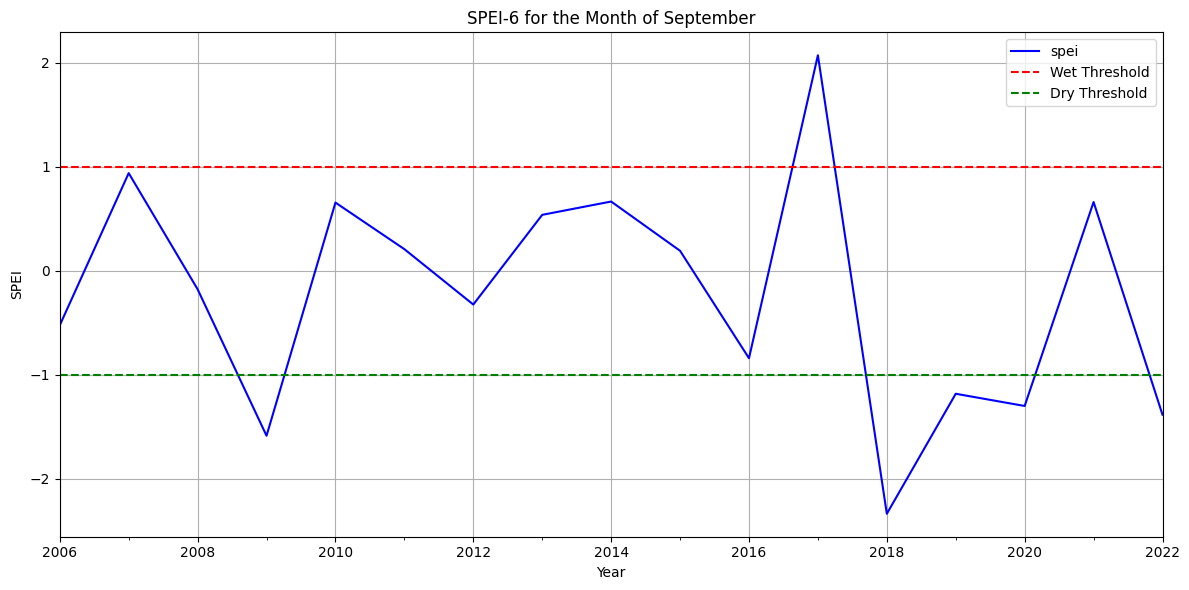

In [23]:
#  MSWEP_hPET
url1 = r'https://data.ceda.ac.uk/badc/hydro-jules/data/Global_drought_indices/MSWEP_hPET'
file_url1 = url_extraction(url1, spei_index = 6)
save_path = r'C:\Users\Pandit\Desktop\documentation\spei_timeseriesplot_MSWEP_hPET_dataset.png'
spei_extraction(file_url1, save_path)

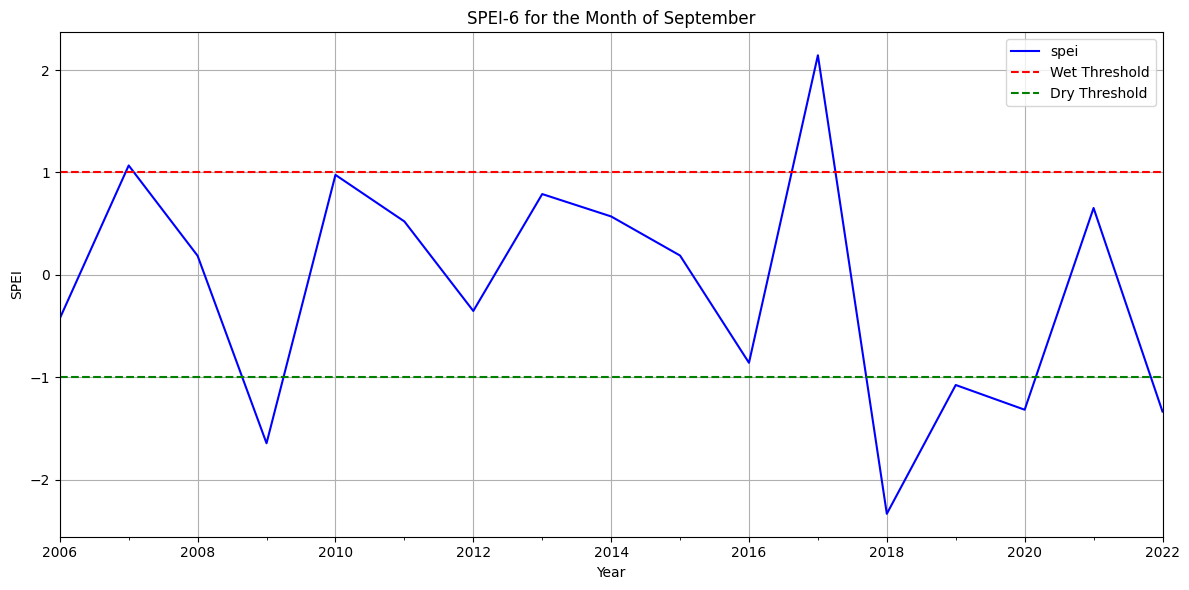

In [24]:
# url of MSWEP_GLEAM
url2 = r'https://data.ceda.ac.uk/badc/hydro-jules/data/Global_drought_indices/MSWEP_GLEAM'
file_url2 = url_extraction(url2, spei_index = 6)
save_path2 = r'C:\Users\Pandit\Desktop\documentation\spei_timeseriesplot_MSWEP_GLEAM_dataset.png'
spei_extraction(file_url2, save_path2)
